### Backtesting Strategy 1 : Monthly Portfolio Rebalancing

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [33]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt

In [4]:
# Below are the KPI functions discussed in Key Performance Measures section
def CAGR(DF):
  # Function to implement the Cumulative Average Annual Growth Rate of a trading strategy
  df = DF.copy()
  df['cum_return'] = (1+df['mon_ret']).cumprod()
  n = len(df)/12
  CAGR = (df['cum_return'].tolist()[-1])**(1/n) - 1
  return CAGR

def volatility(DF):
  # function to calculate annualized volatility of a trading strategy
  df = DF.copy()
  vol = df['mon_ret'].std()*np.sqrt(12)
  return vol

def sharpe(DF, rf):
  # function to calculate sharpe ratio; rf is the risk free rate
  df = DF.copy()
  sr = (CAGR(df) - rf)/volatility(df)
  return sr

def max_dd(DF):
  # function to calculate max drawdown
  df = DF.copy()
  df['cum_return'] = (1+df['mon_ret']).cumprod()
  df['cum_roll_max'] = df['cum_return'].cummax()
  df['drawdown'] = df['cum_roll_max'] - df['cum_return']
  df['drawdown_pct'] = df['drawdown']/df['cum_roll_max']
  max_dd = df['drawdown_pct'].max()
  return max_dd

In [18]:
# Download historical data (monthly) for Dow Jones Index constituent stocks
tickers = ['MMM', 'T', 'BA','AXP', 'CAT', 'CSCO','KO', 'XOM', 'GE','GS','HD','IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MSFT', 'MRK', 'NKE','PFE', 'PG'
'TRV', 'UNH', 'VZ', 'V','DIS', 'WMT']

ohlc_mon = {} # directory with ohlc value for each stock

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
  ohlc_mon[ticker] = yf.download(ticker, period='5y', interval='1mo')
  ohlc_mon[ticker].dropna(inplace=True, how='all')

tickers = ohlc_mon.keys() #redefine ticker variable after removing any tickers with corrupted data
tickers, ohlc_mon['IBM']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

(dict_keys(['MMM', 'T', 'BA', 'AXP', 'CAT', 'CSCO', 'KO', 'XOM', 'GE', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MSFT', 'MRK', 'NKE', 'PFE', 'PGTRV', 'UNH', 'VZ', 'V', 'DIS', 'WMT']),
                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2017-10-01  138.957932  155.363297  138.824097  147.284897  116.114983   
 2017-11-01  147.323135  148.087952  139.780121  147.198853  116.047150   
 2017-12-01  147.609940  150.908218  144.827911  146.673035  116.788391   
 2018-01-01  147.705551  163.604202  146.787766  156.500961  124.613846   
 2018-02-01  156.013382  156.912048  138.049713  148.977051  118.622948   
 ...                ...         ...         ...         ...         ...   
 2022-06-01  139.669998  144.729996  132.850006  141.190002  139.433243   
 2022-07-01  141.000000  141.869995  125.129997  130.789993  129.162628   
 2022-08-01  130.750000  139.339996  128.399994  128.449997

#### Backtesting

In [27]:
# Calculating monthly return for each stock and consolidating return info by stock in a seperate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
  #print("Calculating monthly return for ", ticker)
  ohlc_dict[ticker]['mon_ret'] = ohlc_dict[ticker]['Adj Close'].pct_change()
  return_df[ticker] = ohlc_dict[ticker]['mon_ret']
return_df.dropna(how='all', axis=1, inplace=True)

In [25]:
return_df

,MMM,T,BA,AXP,CAT,CSCO,KO,XOM,GE,GS,...,MSFT,MRK,NKE,PFE,PGTRV,UNH,VZ,V,DIS,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01,0.056258,0.099178,0.072951,0.026876,0.045596,0.101679,-0.004567,-0.000720,-0.092758,0.021280,...,0.011902,0.003267,0.098745,0.034227,NaN,0.085387,0.075841,0.023731,0.071670,0.113618
2017-12-01,-0.027073,0.068719,0.071154,0.016375,0.116401,0.026810,0.010622,0.013496,-0.045926,0.031984,...,0.021380,0.018093,0.035253,0.008024,NaN,-0.030528,0.040086,0.014495,0.025663,0.015633
2018-01-01,0.064282,-0.036780,0.201621,0.000906,0.032999,0.084595,0.037271,0.043759,-0.066955,0.051539,...,0.110708,0.061915,0.094270,0.022640,NaN,0.074027,0.021538,0.089546,0.018921,0.085183
2018-02-01,-0.059840,-0.013637,0.022124,-0.015553,-0.045658,0.086038,-0.091826,-0.132417,-0.127396,-0.018515,...,-0.013052,-0.084894,-0.017444,-0.019709,NaN,-0.044852,-0.107014,-0.010384,-0.050704,-0.155628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,-0.124404,-0.015500,0.040487,-0.178889,-0.171832,-0.053496,-0.007416,-0.098779,-0.186742,-0.085700,...,-0.053120,-0.009345,-0.140093,-0.003440,NaN,0.033918,-0.010528,-0.070245,-0.145237,-0.051373
2022-07-01,0.106870,-0.104007,0.165228,0.115253,0.109029,0.064024,0.027398,0.131831,0.162215,0.122450,...,0.093097,-0.012053,0.127248,-0.036620,NaN,0.059662,-0.089852,0.077302,0.123941,0.086116
2022-08-01,-0.131877,-0.053588,0.005900,-0.013115,-0.061808,-0.005455,-0.038336,-0.013824,-0.006359,-0.002160,...,-0.068640,-0.044549,-0.073703,-0.097585,NaN,-0.042427,-0.083438,-0.063175,0.056362,0.003786


In [28]:
# Function to calculate portfolio return iteratively
def pflio(DF, m, x):
  """ Returns cumulative portfolio return
      DF = dataframe with monthly return info for all stocks
      m = number of stocks in the portfolio
      x = number of underperforming stocks to be removed from portfolio monthly"""
  df = DF.copy()
  portfolio = []
  monthly_ret = [0]
  for i in range(len(df)):
    if len(portfolio) > 0:
      monthly_ret.append(df[portfolio].iloc[i,:].mean())
      bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
      portfolio = [t for t in portfolio if t not in bad_stocks]
    fill = m - len(portfolio)
    new_picks = df.iloc[1,:].sort_values(ascending=False)[:fill].index.values.tolist()
    portfolio = portfolio + new_picks
    print(portfolio)
  monthly_ret_df = pd.DataFrame(np.array(monthly_ret), columns=['mon_ret'])
  return monthly_ret_df

In [30]:
# Calculating overall strategy's KPIs
CAGR(pflio(return_df, 6, 3))

['WMT', 'CSCO', 'T', 'NKE', 'UNH', 'HD']
['WMT', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'T', 'WMT', 'CSCO', 'T', 'NKE']
['WMT', 'CSCO', 'NKE', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['WMT', 'WMT', 'UNH', 'WMT', 'CSCO', 'T']
['CSCO', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['T', 'NKE', 'WMT', 'CSCO', 'T', 'NKE']
['WMT', 'CSCO', 'WMT', 'CSCO', 'T', 'NKE']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['CSCO', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'CSCO', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['T', 'UNH', 'WMT', 'CSCO', 'T', 'NKE']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['T', 'T', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'CSCO', 'T', 'NKE', 'UNH', 'HD']
['CSCO', 'T', 'NKE', 'WMT', 'CSCO', 'T']
['T', 'WMT', '

0.07080175628185126

In [31]:
sharpe(pflio(return_df, 6, 3), 0.025)

['WMT', 'CSCO', 'T', 'NKE', 'UNH', 'HD']
['WMT', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'T', 'WMT', 'CSCO', 'T', 'NKE']
['WMT', 'CSCO', 'NKE', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['WMT', 'WMT', 'UNH', 'WMT', 'CSCO', 'T']
['CSCO', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['T', 'NKE', 'WMT', 'CSCO', 'T', 'NKE']
['WMT', 'CSCO', 'WMT', 'CSCO', 'T', 'NKE']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['CSCO', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'CSCO', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['T', 'UNH', 'WMT', 'CSCO', 'T', 'NKE']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['T', 'T', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'CSCO', 'T', 'NKE', 'UNH', 'HD']
['CSCO', 'T', 'NKE', 'WMT', 'CSCO', 'T']
['T', 'WMT', '

0.2804104729998396

In [32]:
max_dd(pflio(return_df, 6, 3))

['WMT', 'CSCO', 'T', 'NKE', 'UNH', 'HD']
['WMT', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'T', 'WMT', 'CSCO', 'T', 'NKE']
['WMT', 'CSCO', 'NKE', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['WMT', 'WMT', 'UNH', 'WMT', 'CSCO', 'T']
['CSCO', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['T', 'NKE', 'WMT', 'CSCO', 'T', 'NKE']
['WMT', 'CSCO', 'WMT', 'CSCO', 'T', 'NKE']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['CSCO', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'CSCO', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['T', 'UNH', 'WMT', 'CSCO', 'T', 'NKE']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['T', 'T', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'CSCO', 'T', 'NKE', 'UNH', 'HD']
['CSCO', 'T', 'NKE', 'WMT', 'CSCO', 'T']
['T', 'WMT', '

0.19886247637590856

In [35]:
# Calculating KPIS for Index buy and hold strategy over the same period
DJI = yf.download("^DJI", dt.date.today() - dt.timedelta(3650), dt.date.today(), interval='1mo')
DJI['mon_ret'] = DJI['Adj Close'].pct_change().fillna(0)
print(CAGR(DJI))
print(sharpe(DJI, 0.025))
print(max_dd(DJI))

[*********************100%***********************]  1 of 1 completed
0.08927829144958266
0.46619952022054856
0.23201266165063406


['WMT', 'CSCO', 'T', 'NKE', 'UNH', 'HD']
['WMT', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'T', 'WMT', 'CSCO', 'T', 'NKE']
['WMT', 'CSCO', 'NKE', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['WMT', 'WMT', 'UNH', 'WMT', 'CSCO', 'T']
['CSCO', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['T', 'NKE', 'WMT', 'CSCO', 'T', 'NKE']
['WMT', 'CSCO', 'WMT', 'CSCO', 'T', 'NKE']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['CSCO', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['CSCO', 'CSCO', 'T', 'WMT', 'CSCO', 'T']
['CSCO', 'CSCO', 'CSCO', 'WMT', 'CSCO', 'T']
['WMT', 'WMT', 'CSCO', 'T', 'NKE', 'UNH']
['T', 'UNH', 'WMT', 'CSCO', 'T', 'NKE']
['T', 'WMT', 'T', 'WMT', 'CSCO', 'T']
['T', 'T', 'T', 'WMT', 'CSCO', 'T']
['WMT', 'CSCO', 'T', 'NKE', 'UNH', 'HD']
['CSCO', 'T', 'NKE', 'WMT', 'CSCO', 'T']
['T', 'WMT', '

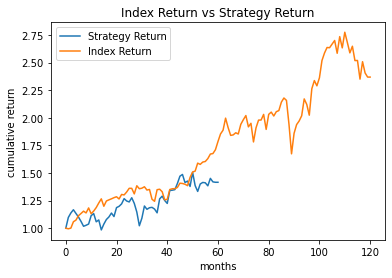

In [36]:
# Visualization
fig, ax = plt.subplots()
plt.plot((1 + pflio(return_df, 6, 3)).cumprod())
plt.plot((1 + DJI['mon_ret'].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(['Strategy Return', 'Index Return'])